# CSD  de Actividad Evocada. 
Usemos esto como opurtunidad para poner todo el código en orden.


En este *notebook* de Julia implementaremos métodos numéricos para llevar a cabo un análisis de *densidad de fuentes y pozos de corriente* sobre una rebanada del hipocámpo de una rata. En este Notebook estudiaremos los datos de los experimentos evocados que hizo Franco en Agosto. La parte de CM la dejaremos en el siguiente Notebook.
 Al parecer primero toca hacer una prueba con todo aquí mismo antes que hacer un modulo ordenado por una inconveniencia al hacer modulos (no se pueden recargar).

In [1]:
using HDF5
using JLD
using PyPlot
matplotlib[:rcParams][:"svg.image_noscale"]=false

false

In [2]:
function AbreyCheca(x::AbstractString)
    #Abre el archivo de brw (acepta el nombre tal cual)
    archivo=h5open(x)
    #sacatito todas las variables que te interesan
    numcuadros=archivo["/3BRecInfo/3BRecVars/NRecFrames"][1][1]
    frecuencia=archivo["/3BRecInfo/3BRecVars/SamplingRate"][1][1]
    maxvolt=archivo["/3BRecInfo/3BRecVars/MaxVolt"][1][1]
    minvolt=archivo["/3BRecInfo/3BRecVars/MinVolt"][1][1]
    bitdepth=archivo["/3BRecInfo/3BRecVars/BitDepth"][1][1]
    duracionexperimento=numcuadros/frecuencia
    factordeescala=(maxvolt-minvolt)/2^bitdepth
    DatosCrudos=read(archivo["/3BData/Raw"])
    result=Dict("numcuadros" => numcuadros,
                "frecuencia"=> frecuencia,
                "maxvolt" => maxvolt,
                "minvolt" => minvolt,
                "bitdepth" => bitdepth,
                "duracion" => duracionexperimento,
                "factor" => factordeescala,
                "DatosCrudos"=>DatosCrudos )
    return result
                    
end

AbreyCheca (generic function with 1 method)

In [55]:
Datos=AbreyCheca("050815_3R11_converted.brw")

Dict{ASCIIString,Any} with 8 entries:
  "minvolt"     => -4125.0
  "maxvolt"     => 4125.0
  "frecuencia"  => 7020.800706028248
  "DatosCrudos" => 4096x210624 Array{UInt16,2}:…
  "bitdepth"    => 0x0c
  "factor"      => 2.01416015625
  "numcuadros"  => 210624
  "duracion"    => 29.99999698312937

In [56]:
#Hay algo raro en el archivo 3R5. Por alguna razón los datos NO estan en array pero en una mugre lista
#DatosCrudosArreglados=reshape(Datos["DatosCrudos"], (4096, Datos["numcuadros"]));
DatosCrudosArreglados=Datos["DatosCrudos"]

4096x210624 Array{UInt16,2}:
 0x0000  0x0000  0x0000  0x0000  0x0000  …  0x0000  0x0000  0x0000  0x0000
 0x07fd  0x07f7  0x0809  0x07ff  0x07f5     0x0803  0x080c  0x0802  0x0801
 0x07ff  0x07f3  0x0805  0x07f6  0x07f6     0x07f2  0x07f2  0x080b  0x0805
 0x07f3  0x07f2  0x0802  0x07f6  0x07dc     0x07ef  0x0806  0x0804  0x07f7
 0x0807  0x07f9  0x0804  0x07ea  0x07e6     0x0806  0x0801  0x0804  0x07f4
 0x07fb  0x07f6  0x080d  0x07f6  0x07f7  …  0x0803  0x0808  0x080b  0x0806
 0x0809  0x07fc  0x080a  0x07fb  0x07f1     0x080b  0x0801  0x0804  0x0813
 0x0801  0x07fd  0x0800  0x0801  0x07e1     0x0802  0x07fe  0x080b  0x0801
 0x07f1  0x07f4  0x0802  0x07fa  0x07eb     0x07f8  0x0803  0x080f  0x07f9
 0x0806  0x07f7  0x07fb  0x07f4  0x07ee     0x07fb  0x0801  0x0805  0x0808
 0x07fa  0x07f1  0x0810  0x07f0  0x07e9  …  0x07f8  0x07f2  0x0815  0x080b
 0x0807  0x07ff  0x0811  0x07f1  0x07ea     0x07f1  0x0801  0x0810  0x080f
 0x07f1  0x07ef  0x0809  0x07ed  0x07f1     0x07f0  0x080b  0x081b  0x0

In [4]:
function EncuentraTrancazosRaw(datos::Array, tolerancia=1400)
    result=Int[]
    longitud=length(datos)
    jcomp=0
    media=mean(datos)
    for j=1:longitud
        if abs(datos[j]-media)>tolerancia
            if j-jcomp>1
                push!(result,j)
            end
            jcomp=j
        end
    end
    return result
end

EncuentraTrancazosRaw (generic function with 2 methods)

In [57]:
exemplo=vec(DatosCrudosArreglados[1500,:]);

In [58]:
size(exemplo)

(210624,)

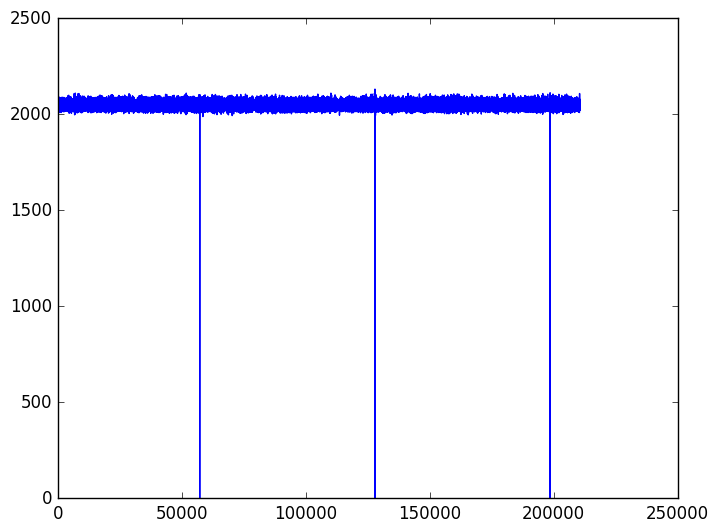

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f0b6cec3d68>

In [59]:
ion()
plot(1:210624,exemplo)

In [60]:
listongas=EncuentraTrancazosRaw(exemplo)

3-element Array{Int64,1}:
  57270
 127878
 198486

Rafael sugiere tomar $5ms$ antes del estímulo y unos $60ms$ después. En cuadros esto resulta ser unos 36 cuadros antes y 420 después.

In [12]:
function ActivAlrededorTrancazo(Lista::Array, xxs::Array)
    #Aqui no se le ha hecho reshape a las matrices todavia
    result=Dict{AbstractString, Array}()
    q=1
    desde=36
    hasta=420
    for j in Lista
        nomineclave="Trancazo_$q"
        result[nomineclave]=xxs[:,j-desde:j+hasta]
        #println(nomineclave)
        q+=1
    end
    return result
end

function ActividadFueraTrancazo(Lista::Array, xxs::Array)
    q=1
    desde=36
    hasta=211
    aux=trues(xxs)
    for j in Lista
        aux[j-desde:j+hasta]=false
    end
    result=zeros(1)
    aux2=find(aux)
    for j in aux2
        result=vcat(result,xxs[j])
    end
    return result
end
        

ActividadFueraTrancazo (generic function with 1 method)

In [61]:
ActividadRaw=ActivAlrededorTrancazo(listongas, DatosCrudosArreglados)
(bla,tmax)=size(ActividadRaw["Trancazo_1"])

(4096,457)

In [14]:
factor=Datos["factor"]
function FormaMatrizDatosCentrados(xxs::Array)
    #El array tiene que ser de 4096 por algo mas
    irrrelevante,largo=size(xxs)
    aux=Array(Int32, 64,64, largo);
    for j=1:64,k=1:64
        aux[k,j,:]=xxs[j+(k-1)*64,:]
    end
    result=(aux*(-1)+2048)*factor;
    aux=0
    return result
end

FormaMatrizDatosCentrados (generic function with 1 method)

In [62]:
FueraTrancazo=ActividadFueraTrancazo(listongas,exemplo);
FueraTrancazo=(FueraTrancazo*(-1)+2048)*factor;


Hay un montonal de canales que por la forma en que requiere ser hecho el experimento no detectaron nada o casi nada. Esos aparecen el registro como saturados en el máximo valor posible. Dado que esto es MUY inconveniente para el cálculo del CM, tenemos que detectarlos automáticamente y ponerlos en cero o ver si los esquivamos.

In [63]:
DatosCentrados=Dict{AbstractString, Array}()
for k in keys(ActividadRaw)
    DatosCentrados[k]=FormaMatrizDatosCentrados(ActividadRaw[k])
end

In [17]:
function BuscaSaturados(datos::Array, saturavalue=1900)
    (ancho,alto,largo)=size(datos)
    result=Set{Array{Int,1}}()
    arreglostd=zeros(ancho,alto)
    arregloprom=zeros(ancho,alto)
    for j=1:ancho, k=1:alto
        prom=mean(datos[k,j,:])
        arregloprom[k,j]=prom
        desviacion=std(datos[k,j,:])
        arreglostd[k,j]=desviacion
        if abs(prom)>saturavalue # || desviacion<1
            push!(result, [k,j])
        end
    end
    return (result,arreglostd, arregloprom)
end

BuscaSaturados (generic function with 2 methods)

In [18]:
function BuscaCanalRespActPot(datos::Array, tini=40)
    #Busquemos los canales con probable respuesta de potencial de accion
    umbral=-200
    (ancho,alto,largo)=size(datos)
    datosaux=datos[:,:,tini:largo] #fuera de la accion maxima del potencial de accion.
    result=Set{Array{Int,1}}()
    for j=1:ancho, k=1:alto
        if minimum(vec(datosaux[k,j,:]))<umbral
            push!(result,[k,j])
        end
    end
    return result
end

BuscaCanalRespActPot (generic function with 2 methods)

In [64]:
PruebaRespuesta=BuscaCanalRespActPot(DatosCentrados["Trancazo_3"])
for q in PruebaRespuesta
    x=q[2]
    y=q[1]
    if x<47
        println(x," ", y)   
    end
end

30 15
41 17
37 15
34 15
35 46
38 17
39 15
30 16
36 15
33 17
42 18
31 17
35 16
38 15
32 17
39 17
36 16
29 16
35 17
41 19
39 18
33 14
39 16
33 15
42 19
37 17
34 14
29 17
40 18
38 18
34 16
37 16
43 20
40 16
36 18
37 18
33 16
32 15
31 16
34 17
36 17
40 17
30 17
38 16
42 20
32 16
32 14


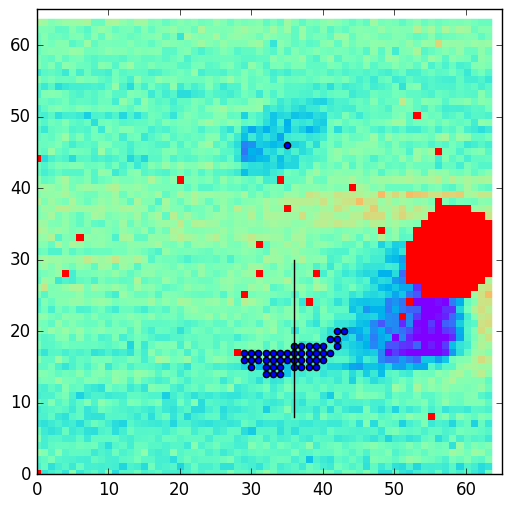

In [65]:
figure(figsize=(6,6))
xlim(0,65)
ylim(0,65)
limites=200
exdesaturado=DatosCentrados["Trancazo_3"][:,:,140];
imagen=imshow(exdesaturado, origin="lower", interpolation="nearest", cmap="rainbow", vmin=-limites,vmax=limites)
plot([36, 36], [30, 8], "k-")
for q in PruebaRespuesta
    x=q[2]
    y=q[1]
    if x<47
    scatter(x,y)   
    end
end

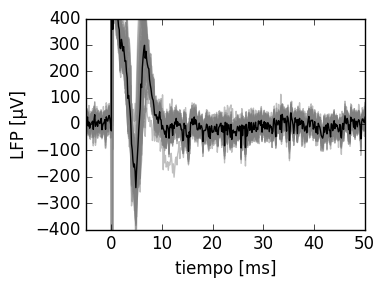

In [66]:
figure(figsize=(4,3))
xlim(-5,50)
limites=400
ylim(-limites,limites)
thewholefockenevent=[]
#exdesaturado=DatosCentrados["Trancazo_2"][:,:,140];
#imagen=imshow(exdesaturado, origin="lower", interpolation="nearest", cmap="rainbow", vmin=-limites,vmax=limites)
promedio=zeros(tmax)
k=0
       tiemporeal=map(x->(x-36)/7.022,1:tmax)
for q in PruebaRespuesta
    x=q[2]
    y=q[1]
    if x<47
    k+=1
    datos=vec(DatosCentrados["Trancazo_3"][y,x,1:tmax])
        thewholefockenevent=vcat(thewholefockenevent,datos)
    promedio+=datos
 
        plot(tiemporeal, datos, c="grey", alpha=0.5)   
    end
end
promedio=promedio/k
plot(tiemporeal, promedio, c="black")
xlabel("tiempo [ms]")
ylabel("LFP [µV]")

tight_layout()

savefig("Respuestas_3R11-01.png", dpi=92)

In [67]:
binsize=8
HistogramaGolpes=hist(thewholefockenevent, -300:binsize:300)

(-300:8:300,[3,3,12,7,8,11,7,11,11,10  …  40,32,32,45,51,50,50,47,24,42])

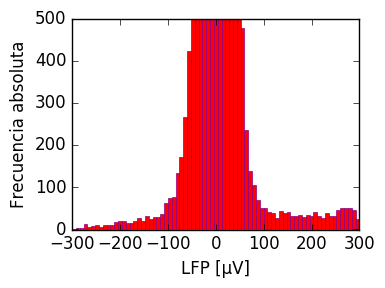

In [68]:
xdata=collect(HistogramaGolpes[1][2:end])
measuredata=HistogramaGolpes[2];
figure(figsize=(4,3))
xlim(-300,300)
ylim(-0.1,500)
bar(xdata,measuredata, binsize, color="red", linewidth=0.5, edgecolor="darkmagenta")
xlabel("LFP [µV]")
ylabel("Frecuencia absoluta")
tight_layout()
savefig("HistogramaDisparosEvocados-3R11.png",dpi=90)

In [69]:
PruebSatu=BuscaSaturados(DatosCentrados["Trancazo_3"])
length(PruebSatu[1])

150

In [70]:
DictSaturados=Dict{AbstractString, Tuple}()
for k in keys(DatosCentrados)
    DictSaturados[k]=BuscaSaturados(DatosCentrados[k])
end

In [27]:
#length(DictSaturados["Trancazo_3"][1])
#DictSaturados["Trancazo_3"][1]
#plot(vec(DatosCentrados["Trancazo_2"][1,1,:]))

In [28]:
function imitaruido(x::Array)
    #Esta funcion asume que x es ruido gaussiano y lo imita.
    #Igual de largo que xx
    sigma=std(x)
    prom=mean(x)
    l=length(x)
    result=sigma*randn(l)+prom
    return result
end

function hazruido(sigma, prom, length)
    # hace ruido
    result=round(Int32, sigma*randn(length)+prom)
    return result
end



hazruido (generic function with 1 method)

In [71]:
binsize=2
HistogramaRuido=hist(FueraTrancazo, -100:binsize:100)

(-100:2:100,[26,31,37,56,35,118,63,89,95,146  …  30,29,20,12,15,9,3,5,2,2])

In [72]:
sigmaruido=std(FueraTrancazo)
promruido=mean(FueraTrancazo)
(promruido,sigmaruido)

(-0.4399116716734721,28.154419011879412)

In [73]:
RuidoArtificial=imitaruido(FueraTrancazo)
HistoRuidoArtificial=hist(RuidoArtificial,-100:binsize:100)
norma=length(RuidoArtificial)
mean(RuidoArtificial),std(RuidoArtificial)


(-0.4984576911602655,28.133824113750983)

In [74]:
mu=promruido
sigma=sigmaruido
function gauss(x)
    return 1/(sqrt(2*pi)*sigma)*exp(-((x-mu)/sigma)^2/2)
end

gauss (generic function with 1 method)

In [75]:
xdata=collect(HistogramaRuido[1][2:end])
measuredata=HistogramaRuido[2];

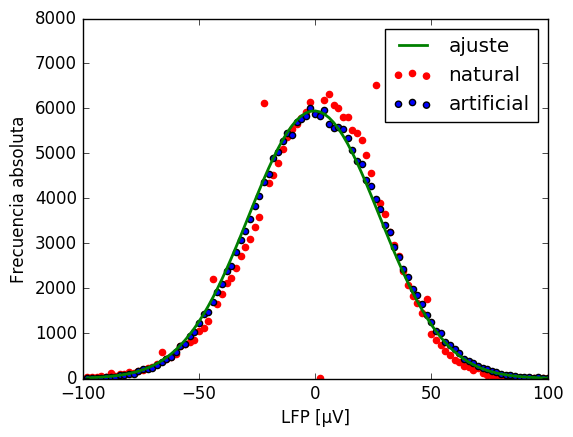

In [76]:
figure(figsize=(6,4.5))
xlim(-100,100)
ylim(-0.1,8000)
scatter(xdata,measuredata, color="red", label="natural")
scatter(HistoRuidoArtificial[1][2:end],HistoRuidoArtificial[2], label="artificial")
plot(xdata, map(x->binsize*norma*gauss(x),xdata), color="green",lw=2, label="ajuste")
legend()
xlabel("LFP [µV]")
ylabel("Frecuencia absoluta")
savefig("GaussianasBonitas_3R11.png", dpi=96)

In [36]:
function vecindad8(punto::Array)
    j=punto[1]
    k=punto[2]
    result=Set{Array{Int64,1}}()
    push!(result, [j-1,k-1])
    push!(result, [j-1,k])
    push!(result, [j-1,k+1])
    push!(result, [j,k-1])
    push!(result, [j,k+1])
    push!(result, [j+1,k-1])
    push!(result, [j+1,k])
    push!(result, [j+1,k+1])
    return result
end

function promediasobreconjunto(puntos::Set, datos::Array)
    n=0
    result=0
    for q in puntos
        result+=datos[q[1],q[2]]
        n+=1
    end
    result/=n
    return result
end
        

promediasobreconjunto (generic function with 1 method)

In [37]:
largo

LoadError: LoadError: UndefVarError: largo not defined
while loading In[37], in expression starting on line 1

In [77]:
length(DatosCentrados["Trancazo_1"][1,1,:])

457

In [78]:
DatosDesaturados=Dict{AbstractString, Array}()
n=0
l=0
for k in keys(DatosCentrados)
    largo=length(DatosCentrados[k][1,1,:])
    lista=DictSaturados[k][1]
    aux=copy(DatosCentrados[k])
   # println(k," ",length(lista))
    
     for m in lista
        conjuntoutil=setdiff(vecindad8(m),lista)
        q=m[1]
        p=m[2]
     #   if isempty(conjuntoutil)   
            aux[q,p,:]=hazruido(sigmaruido,promruido,largo)
            n+=1
     #   else
     #       for t=1:tmax
     #           aux[q,p,t]=promediasobreconjunto(conjuntoutil,aux[:,:,t])
     #       end
     #       l+=1
     #   end
     end
    DatosDesaturados[k]=aux
end
print(n,", ",l)

460, 0

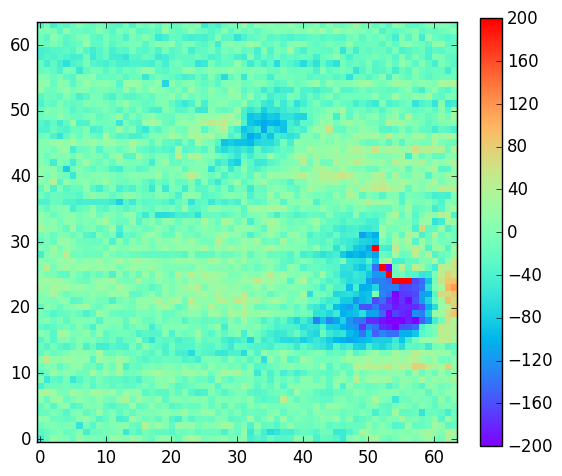

In [79]:
ion()
limites=200
figure(figsize=(6,6))

exdesaturado=DatosDesaturados["Trancazo_2"][:,:,140];
imagen=imshow(exdesaturado, origin="lower", interpolation="nearest", cmap="rainbow", vmin=-limites,vmax=limites)
cb=colorbar(imagen, fraction=0.046)
savefig("LFP_Desaturado_3R11-340.svg", dpi=96)

In [87]:
save("LFPDesaturado_3R11.jld", "LFPDenoized", DatosDesaturados, "LFPSaturados", DatosCentrados)

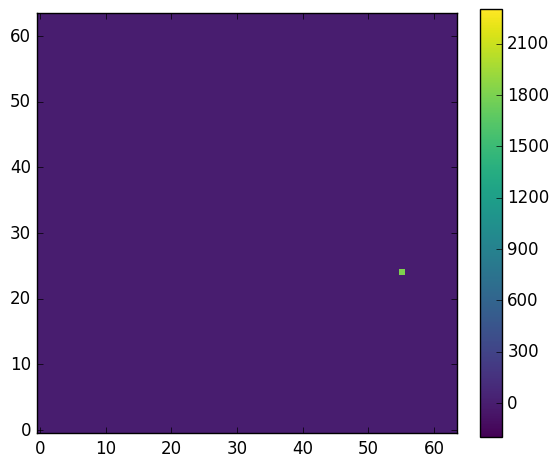

PyObject <matplotlib.colorbar.Colorbar object at 0x7f0ace818fd0>

In [80]:
limites=2300
figure(figsize=(6,6))
rara=zeros(64,64)
exdesaturado=mean!(rara, DatosDesaturados["Trancazo_2"]);
map!(x->x>1800?x:0, exdesaturado)
imagen=imshow(exdesaturado, origin="lower", interpolation="nearest", cmap="viridis", vmin=-200,vmax=limites)
cb=colorbar(imagen, fraction=0.046)

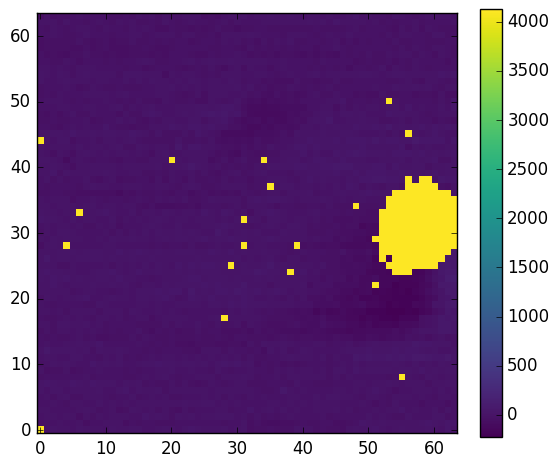

PyObject <matplotlib.colorbar.Colorbar object at 0x7f0ac3d74f60>

In [81]:
figure(figsize=(6,6))
exsaturado=DatosCentrados["Trancazo_2"][:,:,140];
imagen=imshow(exsaturado, origin="lower", interpolation="nearest", cmap="viridis")
cb=colorbar(imagen,fraction=0.046)
#savefig("LFP_Saturado_1-340.svg", dpi=96)

In [82]:
PyPlot.ioff()
limites=200
for t=1:tmax 
    tau=t-36
    milisec=round(tau/7.02, 2)   
    exdesaturado=DatosDesaturados["Trancazo_2"][:,:,t];
    figure(figsize=(6,6))
    imagen=imshow(exdesaturado, origin="lower", interpolation="nearest", vmin=-limites,vmax=limites, cmap="jet")
    cb=colorbar(imagen, fraction=0.046)
    PyPlot.title("t= $milisec ms")
    
    savefig("LFP_Desaturado_2_3R11-$t.png", dpi=96)
    close()
end

In [46]:
function UnNormGauss(x,sigma)
    return exp(-x*x/(2*sigma))
end

function GaussSuavizarTemporal(Datos,Sigma=3)  
    #sigma esta medido en pixeles, es la desviacion estandar de nuestro kernel.
    #El medioancho de nuestra ventana seran 3*sigma
    #Esto es escencialmente un filtro pasabajos
    medioancho=ceil(Sigma*3)
    colchon=ones(medioancho)
    result=zeros(Datos)
    datoscolchon=vcat(colchon*Datos[1], Datos, colchon*Datos[end])
    kernel=map(x->UnNormGauss(x,Sigma), collect(-medioancho:medioancho))
    kernel=kernel/(sum(kernel))
    #La convolucion asi normalizada preserva el valor RELATIVO entre los puntos de la funcion.
    #pero queremos ponerlo mas parecido a los voltajes que medimos, para preservar el rango de valores
    #experimentales y su criterio de potenciales de accion / ruido
    for t=medioancho+1:length(Datos)+medioancho
        result[t-medioancho]=sum(datoscolchon[t-medioancho:t+medioancho].*kernel)
    end
    a=maximum(abs(Datos))
    b=maximum(abs(result))
    #nromalizacion 
    #result=result*a/b
    return result
end   

GaussSuavizarTemporal (generic function with 2 methods)

In [47]:
#De momento todo "in file"
GaussianKernel=[0.00000067	0.00002292	0.00019117	0.00038771	0.00019117	0.00002292	0.00000067
0.00002292	0.00078634	0.00655965	0.01330373	0.00655965	0.00078633	0.00002292
0.00019117	0.00655965	0.05472157	0.11098164	0.05472157	0.00655965	0.00019117
0.00038771	0.01330373	0.11098164	0.22508352	0.11098164	0.01330373	0.00038771
0.00019117	0.00655965	0.05472157	0.11098164	0.05472157	0.00655965	0.00019117
0.00002292	0.00078633	0.00655965	0.01330373	0.00655965	0.00078633	0.00002292
    0.00000067	0.00002292	0.00019117	0.00038771	0.00019117	0.00002292	0.00000067]

function GaussianSmooth(Datos)
    tamanodatos=size(Datos)
    result=zeros(Datos)
    temp=copy(Datos)
    #Primero, hacemos el padding de los datos para que no se suavice demasiado
    for j=1:3
        temp=vcat(temp[1,:], temp, temp[end,:])
    end
    for j=1:3
        temp=hcat(temp[:,1], temp, temp[:,1])
    end
    
    for j=4:tamanodatos[1]+3, k=4:tamanodatos[2]+3
        #los indices van primero, "renglones", luego "columnas", etc
        aux=temp[j-3:j+3,k-3:k+3]
        result[j-3,k-3]=sum(GaussianKernel.*aux)
    end
    #Esta convolución no respeta norma L2
    #result=result*maximum(abs(Datos))/maximum(abs(result))
    return result
end



GaussianSmooth (generic function with 1 method)

In [48]:
#checa que Julia va ordenando los datos renglon por renglon, no columna por columna
LaplacianTerm1=[[0 1 0]; [1 -4 1]; [0 1 0]]
LaplacianTerm2=[[0.5 0 0.5]; [0 -2 0]; [0.5 0 0.5]]
LaplacianKernel=(1-1/3)*LaplacianTerm1+(1/3)*LaplacianTerm2

#Nueva variante: AHORA SI VAMOS A ELIMINAR LAS ORILLAS
#Los efectos de borde estan dando puro choro en el CSD.
function DiscreteLaplacian(Datos)
    result=zeros(Datos)
    temp=copy(Datos)
    #Primero, hacemos el padding de los datos para que no se suavice demasiado
    temp=vcat(temp[1,:], temp, temp[end,:])
    temp=hcat(temp[:,1], temp, temp[:,end])
    largo,ancho=size(Datos)
    aux=Array(Float64,(3,3))
    result=zeros(Datos)
    for j=2:largo-1, k=2:ancho-1
        #los indices van primero, "renglones", luego "columnas", etc
        aux=temp[j-1:j+1,k-1:k+1]
        result[j,k]=sum(LaplacianKernel.*aux)
    end
    #DO NOT Crop the borders
    return result
end

DiscreteLaplacian (generic function with 1 method)

In [83]:
CSD=Dict{AbstractString, Array}()
for k in keys(DatosDesaturados)
    (mu,nu,lu)=size(DatosDesaturados[k])
    aux1=zeros(mu,nu,lu)
    aux2=zeros(mu,nu,lu)
    temp=map(Float64,DatosDesaturados[k])
    for t=1:lu
        aux1[:,:,t]=GaussianSmooth(temp[:,:,t])
        aux2[:,:,t]=DiscreteLaplacian(aux1[:,:,t])
    end
    CSD[k]=-aux2
end

In [50]:
CSDPlanchada=Dict{AbstractString, Array}()
for k in keys(CSD)
    (mu,nu,lu)=size(CSD[k])
    aux=zeros(mu,nu,lu)
    for j=1:mu,l=1:nu
        porromponpon=vec(CSD[k][j,l,:])
        aux[j,l,:]=GaussSuavizarTemporal(porromponpon)
    end
    CSDPlanchada[k]=aux
end

In [51]:
CSDPromedio=CSDPlanchada["Trancazo_1"]+CSDPlanchada["Trancazo_2"]+CSDPlanchada["Trancazo_3"];
CSDPromedio/=3.0;

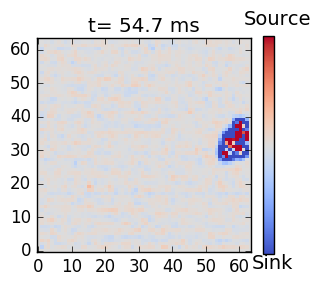

In [84]:
ion()
t=420
tau=t-36
milisec=round(tau/7.02, 2)
CSDexample=CSDPromedio[:,:,t];

figure(figsize=(3,3))
#exsaturado=DatosCentrados["Trancazo_1"][:,:,340]+DatosCentrados["Trancazo_3"][:,:,340]+DatosCentrados["Trancazo_2"][:,:,340]
imagen=imshow(CSDexample, origin="lower", interpolation="nearest", cmap="coolwarm", vmin=-40, vmax=40)
cb=colorbar(imagen,fraction=0.046, ticks=[])
 PyPlot.title("t= $milisec ms")

   
    annotate("Source",
    xy=[1.03;0.98],
    xycoords="axes fraction",
    xytext=[-10,10],
    textcoords="offset points",
#font_properties=("DejaVu Serif"),
    fontsize=14,
    ha="left",
   va="bottom")


annotate("Sink",
    xy=[1.07;-0.16],
    xycoords="axes fraction",
    xytext=[-10,10],
    textcoords="offset points",
    fontsize=14.0,
    ha="left",
    va="bottom")
    
tight_layout()  
#savefig("CSDSuave_1-$t.png", dpi=96)


In [85]:

PyPlot.ioff()
for t=1:tmax
    tau=t-36
    milisec=round(tau/7.02, 1)
    
    datos=CSDPromedio[:,:,t];
    figure(figsize=(3,3))
    imagen=imshow(datos, origin="lower", interpolation="nearest", vmin=-60,vmax=60, cmap="coolwarm")
    cb=colorbar(imagen, fraction=0.046, ticks=[])
    PyPlot.title("t= $milisec ms")
    
    annotate("Source",
    xy=[1.03;0.98],
    xycoords="axes fraction",
    xytext=[-10,10],
    textcoords="offset points",
#font_properties=("DejaVu Serif"),
    fontsize=14,
    ha="left",
   va="bottom")


annotate("Sink",
    xy=[1.07;-0.16],
    xycoords="axes fraction",
    xytext=[-10,10],
    textcoords="offset points",
    fontsize=14.0,
    ha="left",
    va="bottom")
    
    tight_layout()    
    savefig("CSDPromedio_3R11-$t.png", dpi=96)
    close()
end

In [86]:
save("CSDEvocada_3R11.jld", "CSDPlanchada", CSDPlanchada, "CSD", CSD)